# Word Cloud

## 1.Collect Tweets into MongoDB 

### Install Python libraries
You may need to restart your Jupyter Notebook instance after installed those libraries.

In [1]:
!pip install pymongo

In [2]:
!pip install pymongo[srv]

In [3]:
!pip install dnspython

In [4]:
!pip install tweepy

In [5]:
!pip install twitter

In [6]:
pip install certifi

Note: you may need to restart the kernel to use updated packages.


### Import Python libraries

In [7]:
import pymongo
from pymongo import MongoClient
import json
import tweepy
import twitter
from pprint import pprint
import configparser
import pandas as pd
import certifi

### Load the Authorization Info
Save database connection info and API Keys in a config.ini file and use the configparse to load the authorization info.

In [9]:
config = configparser.ConfigParser()
config.read('config.ini')

CONSUMER_KEY      = config['mytwitter']['api_key']
CONSUMER_SECRET   = config['mytwitter']['api_secrete']
OAUTH_TOKEN       = config['mytwitter']['access_token']
OATH_TOKEN_SECRET = config['mytwitter']['access_secrete']

mongod_connect = config['mymongo']['connection']

### Connect to the MongoDB Cluster
the name database and collection is here.

In [10]:
ca = certifi.where()                                 # Fix SSR error

client = MongoClient(mongod_connect , tlsCAFile=ca)  # connect to mongo and fix SSL problem with tlsCAFile=ca
db = client.Twitter                                  # use or create a database named Twitter
tweet_collection = db.new_tweet_collection           # use or create a collection named tweet_collection

## Setup tweepy

In [11]:
# Setup tweepy to authenticate with Twitter credentials:
stream_auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
stream_auth.set_access_token(OAUTH_TOKEN, OATH_TOKEN_SECRET)

### Authorize the Stream API

In [22]:
# Create the api to connect to twitter with your creadentials
stream_api = tweepy.API(stream_auth)

In [23]:
wait_on_rate_limit= True;  # will make the api to automatically wait for rate limits to replenish
wait_on_rate_limit_notify= True;  # will make the api  to print a notification when Tweepyis waiting for rate limits to replenish

## Stream Listener && Collect to MongoDB

In [113]:
class StreamListener(tweepy.StreamListener):
    counter = 0
    
    def __init__(self, max_tweets=1000, *args, **kwargs):
        self.max_tweets = max_tweets
        self.counter = 0
        super().__init__(*args, **kwargs)
        
    def on_connect(self):
        self.counter = 0

    def on_status(self, status):
        
        # make sure the collected tweets are unique
        abc = tweet_collection.find_one({'id_str': status.id})
        if abc!=None:
            print("same data in collection")
            return 
        
        ### Store tweet to MongoDB      
        # get some text
        #print(self.counter)
        #print(status.text)
        
        # After Get Full text
        # Check if Retweet
        if hasattr(status, "retweeted_status"):  
            try:
                print(status.retweeted_status.extended_tweet["full_text"])
                full_text1 = status.retweeted_status.extended_tweet["full_text"]
                StreamListener.collectToMongo(self,self.counter,status.id,full_text1)
            except AttributeError:
                print(status.retweeted_status.text)
                full_text2 = status.retweeted_status.text
                StreamListener.collectToMongo(self,self.counter,status.id,full_text2)
        else:
            try:
                print(status.extended_tweet["full_text"])
                full_text3 = status.extended_tweet["full_text"]
                StreamListener.collectToMongo(self,self.counter,status.id,full_text3)
            except AttributeError:
                print(status.text)
                full_text4 = status.text
                StreamListener.collectToMongo(self,self.counter,status.id,full_text4)
                
        # count max tweet
        if self.counter >= self.max_tweets:
            stream.disconnect()  
            
    def on_error(self, status_code):
        if status_code == 420:
            return False
        
    def collectToMongo(self,counter,idTweet,full_text):
        # collection stucture
        new_tweet = {
            'id_doc': counter,
            'id_str': idTweet,
            'full_text': full_text,
        }
        tweet_collection.insert_one(new_tweet)
        
        # Increment counter
        self.counter += 1
        print("============== ",self.counter, "documents insert ==============\n\n")

## Connect to a streaming API

In [57]:
# number of returned tweets
max_tweets = 10    

# define the keywords, tweets contain election                                
keywords = ["#ThreeManDown",
            "อนุทิน"
           ]

# defin the location, in Harrisonburg, VA
# geocode = "38.4392897,-78.9412224,50mi"      

In [114]:
stream_listener = StreamListener(max_tweets)
stream = tweepy.Stream(auth=stream_api.auth, listener=stream_listener)
stream.filter(track=keywords)

วันที่พ่อผมเสีย ผมเห็นข่าว #อนุทิน เล่นคีย์บอร์ดในบางซื่ออย่างเมามัน ในวันนี้ที่ผมต้องเริ่มกินยาแก้วิตกกังวลเพราะผลจากความสูญเสีย ผมเห็นข่าว #อนุทิน บอกโควิดกระจอก 

ตอนนี้ผมอยากเอารองเท้าเหยียบขี้หมาไปตบปากอนุทินจนกว่าขี้หมามันจะซึมเอาไปในสมองอันอวดดีของ #อนุทิน ครับ
==============  1 documents insert ==============


โคตรดีย์ #ThreeManDown https://t.co/xRwFJ6VWPo
==============  2 documents insert ==============


เราจะเป็นถ่านให้พวกคุณตลอดไป
ถ่านที่มันจะไม่มีวันมอดไหม้ 
จนกว่าคุณอยากจะดับมันเอง...

"ชาวเมืองโคตรรักพวกคุณเลย"
#timezone
#ThreeManDown https://t.co/gf6BxrGEVq
==============  3 documents insert ==============


ไทยเคยมีบทเรียนมาหลายซีซั่นแล้วนะ ยังจะมาชะล่าใจอีก #อนุทิน
==============  4 documents insert ==============


วันที่พ่อผมเสีย ผมเห็นข่าว #อนุทิน เล่นคีย์บอร์ดในบางซื่ออย่างเมามัน ในวันนี้ที่ผมต้องเริ่มกินยาแก้วิตกกังวลเพราะผลจากความสูญเสีย ผมเห็นข่าว #อนุทิน บอกโควิดกระจอก 

ตอนนี้ผมอยากเอารองเท้าเหยียบขี้หมาไปตบปากอนุทินจนกว่าขี้หมามันจะซึมเอาไปในสมองอันอวดดีขอ

In [115]:
tweet_json = list(tweet_collection.find())

In [119]:
tweet_json

[{'_id': ObjectId('61bf65296efe01b1457416c0'),
  'id_doc': 0,
  'id_str': 1472612770373726215,
  'full_text': 'วันที่พ่อผมเสีย ผมเห็นข่าว #อนุทิน เล่นคีย์บอร์ดในบางซื่ออย่างเมามัน ในวันนี้ที่ผมต้องเริ่มกินยาแก้วิตกกังวลเพราะผลจากความสูญเสีย ผมเห็นข่าว #อนุทิน บอกโควิดกระจอก \n\nตอนนี้ผมอยากเอารองเท้าเหยียบขี้หมาไปตบปากอนุทินจนกว่าขี้หมามันจะซึมเอาไปในสมองอันอวดดีของ #อนุทิน ครับ'},
 {'_id': ObjectId('61bf652b6efe01b1457416c1'),
  'id_doc': 1,
  'id_str': 1472612781333487618,
  'full_text': 'โคตรดีย์ #ThreeManDown https://t.co/xRwFJ6VWPo'},
 {'_id': ObjectId('61bf652d6efe01b1457416c2'),
  'id_doc': 2,
  'id_str': 1472612788958728196,
  'full_text': 'เราจะเป็นถ่านให้พวกคุณตลอดไป\nถ่านที่มันจะไม่มีวันมอดไหม้ \nจนกว่าคุณอยากจะดับมันเอง...\n\n"ชาวเมืองโคตรรักพวกคุณเลย"\n#timezone\n#ThreeManDown https://t.co/gf6BxrGEVq'},
 {'_id': ObjectId('61bf652e6efe01b1457416c3'),
  'id_doc': 3,
  'id_str': 1472612790921662468,
  'full_text': 'ไทยเคยมีบทเรียนมาหลายซีซั่นแล้วนะ ยังจะมาชะล่าใจอีก #อนุทิน'}

### cut word

In [120]:
def cutword(wordinput):
    wordmodify = wordinput+"`"

    #ตัดชื่อคน รีทวิต
    Tweet = wordmodify.find("RT") 
    endnameTweet = wordmodify.find(":")
    substring = wordmodify[Tweet:endnameTweet+1]
    # print(substring)

    cutTweet=wordmodify.replace(substring,"")
    # print(cutTweet)

    #ตัดหลัง https
    https = cutTweet.find("https://t.co") 
    endpoint = cutTweet.find("`")
    substring = cutTweet[https:endpoint+1]
    # print(substring)

    aa=cutTweet.replace(substring,"")
    # print(aa)
    return aa

In [128]:
print("Before : ", tweet_json[1]['full_text'] )

print("After :  ",cutword(tweet_json[1]['full_text']))

Before :  โคตรดีย์ #ThreeManDown https://t.co/xRwFJ6VWPo
After :   โคตรดีย์ #ThreeManDown 


In [129]:
all_tweet = ""

for i in range(tweet_collection.count_documents({})):
  all_tweet += cutword(tweet_json[i]['full_text'])+"\n"

print(all_tweet)

วันที่พ่อผมเสีย ผมเห็นข่าว #อนุทิน เล่นคีย์บอร์ดในบางซื่ออย่างเมามัน ในวันนี้ที่ผมต้องเริ่มกินยาแก้วิตกกังวลเพราะผลจากความสูญเสีย ผมเห็นข่าว #อนุทิน บอกโควิดกระจอก 

ตอนนี้ผมอยากเอารองเท้าเหยียบขี้หมาไปตบปากอนุทินจนกว่าขี้หมามันจะซึมเอาไปในสมองอันอวดดีของ #อนุทิน ครับ
โคตรดีย์ #ThreeManDown 
เราจะเป็นถ่านให้พวกคุณตลอดไป
ถ่านที่มันจะไม่มีวันมอดไหม้ 
จนกว่าคุณอยากจะดับมันเอง...

"ชาวเมืองโคตรรักพวกคุณเลย"
#timezone
#ThreeManDown 
ไทยเคยมีบทเรียนมาหลายซีซั่นแล้วนะ ยังจะมาชะล่าใจอีก #อนุทิน
วันที่พ่อผมเสีย ผมเห็นข่าว #อนุทิน เล่นคีย์บอร์ดในบางซื่ออย่างเมามัน ในวันนี้ที่ผมต้องเริ่มกินยาแก้วิตกกังวลเพราะผลจากความสูญเสีย ผมเห็นข่าว #อนุทิน บอกโควิดกระจอก 

ตอนนี้ผมอยากเอารองเท้าเหยียบขี้หมาไปตบปากอนุทินจนกว่าขี้หมามันจะซึมเอาไปในสมองอันอวดดีของ #อนุทิน ครับ
Go to my ➡️
#NewProfilePic2️⃣0️⃣2️⃣1️⃣ #CLUAND #เลิกลวนลามศิลปิน #confinamiento #h96svw #อนุทิน #JaeDo #LISAonPENSHOPPETVTake2 #LALISA #sgsupatt #SpiderMan 
วันที่พ่อผมเสีย ผมเห็นข่าว #อนุทิน เล่นคีย์บอร์ดในบางซื่ออย่างเมามัน ในวันนี้ที่ผม

### drop collection

In [130]:
tweet_collection.drop()

# 2.Word Cloud ภาษาไทย

In [131]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [132]:
conda install -c conda-forge wordcloud

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [133]:
pip install pythainlp

Note: you may need to restart the kernel to use updated packages.


In [134]:
import pythainlp
from pythainlp import word_tokenize
from pythainlp.corpus import get_corpus # for getting stopwords

import wordcloud
from wordcloud import WordCloud

import matplotlib.pyplot as plt
import numpy as np
import re

%matplotlib inline
%config InlineBackend.figure_format='retina'

## แบ่งคำแล้วแยกแต่ละคำด้วยช่องว่าง

In [135]:
words = word_tokenize(all_tweet)
print(words)

['วันที่', 'พ่อ', 'ผม', 'เสีย', ' ', 'ผม', 'เห็น', 'ข่าว', ' ', '#', 'อนุทิน', ' ', 'เล่น', 'คีย์บอร์ด', 'ใน', 'บาง', 'ซื่อ', 'อย่าง', 'เมามัน', ' ', 'ใน', 'วันนี้', 'ที่', 'ผม', 'ต้อง', 'เริ่ม', 'กิน', 'ยา', 'แก้', 'วิตกกังวล', 'เพราะ', 'ผล', 'จาก', 'ความสูญเสีย', ' ', 'ผม', 'เห็น', 'ข่าว', ' ', '#', 'อนุทิน', ' ', 'บอก', 'โควิด', 'กระจอก', ' ', '\n', '\n', 'ตอนนี้', 'ผม', 'อยาก', 'เอา', 'รองเท้า', 'เหยียบ', 'ขี้หมา', 'ไป', 'ตบ', 'ปาก', 'อนุทิน', 'จนกว่า', 'ขี้หมา', 'มัน', 'จะ', 'ซึม', 'เอา', 'ไป', 'ใน', 'สมอง', 'อัน', 'อวดดี', 'ของ', ' ', '#', 'อนุทิน', ' ', 'ครับ', '\n', 'โคตร', 'ดี', 'ย์', ' ', '#', 'ThreeManDown', ' ', '\n', 'เรา', 'จะ', 'เป็น', 'ถ่าน', 'ให้', 'พวกคุณ', 'ตลอดไป', '\n', 'ถ่าน', 'ที่', 'มัน', 'จะ', 'ไม่', 'มี', 'วัน', 'มอดไหม้', ' ', '\n', 'จนกว่า', 'คุณ', 'อยาก', 'จะ', 'ดับ', 'มัน', 'เอง', '...', '\n', '\n', '"', 'ชาวเมือง', 'โคตร', 'รัก', 'พวกคุณ', 'เลย', '"', '\n', '#', 'timezone', '\n', '#', 'ThreeManDown', ' ', '\n', 'ไทย', 'เคย', 'มี', 'บทเรียน', 'มา', 'หลาย',

In [136]:
all_words = ' '.join(words).lower().strip()
# all_word = re.sub('(\n|\s{2})', '', all_words)
all_words[:500]

'วันที่ พ่อ ผม เสีย   ผม เห็น ข่าว   # อนุทิน   เล่น คีย์บอร์ด ใน บาง ซื่อ อย่าง เมามัน   ใน วันนี้ ที่ ผม ต้อง เริ่ม กิน ยา แก้ วิตกกังวล เพราะ ผล จาก ความสูญเสีย   ผม เห็น ข่าว   # อนุทิน   บอก โควิด กระจอก   \n \n ตอนนี้ ผม อยาก เอา รองเท้า เหยียบ ขี้หมา ไป ตบ ปาก อนุทิน จนกว่า ขี้หมา มัน จะ ซึม เอา ไป ใน สมอง อัน อวดดี ของ   # อนุทิน   ครับ \n โคตร ดี ย์   # threemandown   \n เรา จะ เป็น ถ่าน ให้ พวกคุณ ตลอดไป \n ถ่าน ที่ มัน จะ ไม่ มี วัน มอดไหม้   \n จนกว่า คุณ อยาก จะ ดับ มัน เอง ... \n \n " ชาวเม'

### \n
ตัด \n ออก

In [ ]:
# re.sub('(\n|\s{2})', '', all_words)

### stop word 
คำคือที่เราไม่ต้องการเอา

In [141]:
stopwords = {'\n','.','\\',"\'",'/','#'} # set
print(type(stopwords))
print(stopwords)

<class 'set'>
{'\n', '\\', '#', '.', '/', "'"}


## Word cloud
* colormap: https://matplotlib.org/3.3.3/tutorials/colors/colormaps.html
* color name: https://matplotlib.org/3.1.0/gallery/color/named_colors.html
* sample mask images: https://github.com/prasertcbs/img/tree/master/mask

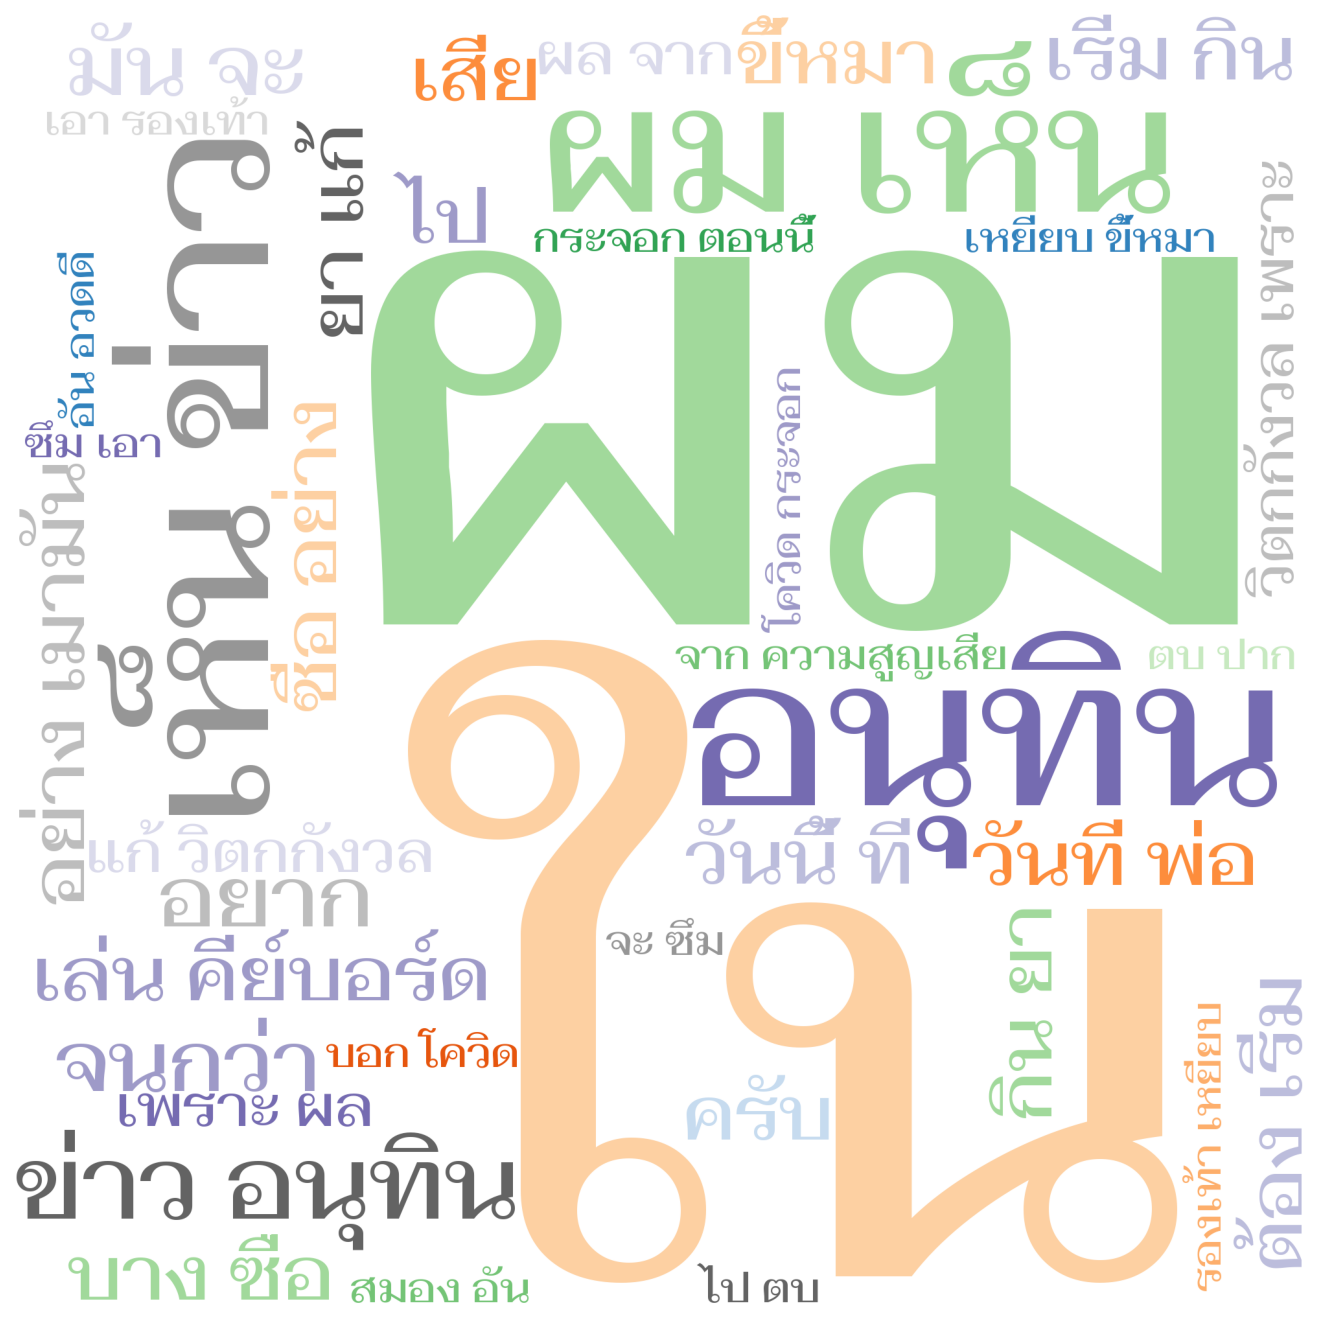

In [142]:
wordcloud = WordCloud(
#     font_path='c:/windows/fonts/browalia.ttc',
#     font_path='C:/Users/thirawat/Desktop/word_cloud_thai/font_path/Fahkwang-Medium.ttf',
#     font_path='font_path/Kanit-Black.ttf',
    font_path='font_path/Fahkwang-Medium.ttf',
    regexp='[ก-๙]+',

    stopwords=stopwords,
    width=2000, height=2000,

    prefer_horizontal=.9,
    max_words=40, 

#     colormap='viridis', # default matplotlib colormap
    colormap='tab20c',
#     colormap='plasma',
    background_color = 'white').generate(all_words)
plt.figure(figsize = (10, 9))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
# plt.show()